In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import datetime as dt
from statsmodels.tsa.stattools import adfuller
from sklearn.decomposition import PCA

In [2]:
def parser(x):
	return dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

In [3]:
def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

In [4]:
# ADF test function to check stationarity and suggest differencing (d) value
def check_stationarity_and_find_d(series):
    p_value_threshold = 0.05
    d = 0
    adf_result = adfuller(series)
    print(f"ADF Statistic (d={d}): {adf_result[0]}, p-value: {adf_result[1]}")
    
    # If series is not stationary (p-value > 0.05), apply differencing and test again
    while adf_result[1] > p_value_threshold:
        d += 1
        series = series.diff().dropna()
        adf_result = adfuller(series)
        print(f"ADF Statistic (d={d}): {adf_result[0]}, p-value: {adf_result[1]}")
    
    print(f"Recommended d value: {d}")
    return d

In [5]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data

In [6]:
# TODO: Make it better
from pathlib import Path

# Define the path
project_root = Path("C:/Users/cigde/ts_anomaly_detection_thesis/ts_anomaly_detection_thesis")
file_path = project_root / "data" / "grok_asg_anomaly.csv"

print(file_path)  # Output: C:/Users/ece/ts_anomaly_detection_thesis/data/example.csv

C:\Users\cigde\ts_anomaly_detection_thesis\ts_anomaly_detection_thesis\data\grok_asg_anomaly.csv


In [7]:
# some turkish 
fname = f"data\\grok_asg_anomaly.csv"

data = pd.read_csv(file_path, header=0, parse_dates=[0], index_col=0, date_parser=parser)

C:\Users\cigde\AppData\Local\Temp\ipykernel_26816\2909950521.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv(file_path, header=0, parse_dates=[0], index_col=0, date_parser=parser)


In [8]:
#data = data[:3650]

In [9]:
test_stationarity(data, 'value')

'Non-Stationary'

In [10]:
# Applying the function to the data to find the appropriate differencing (d) value
recommended_d = check_stationarity_and_find_d(data['value'])
recommended_d

ADF Statistic (d=0): -0.6872306404260928, p-value: 0.8500294226198652
ADF Statistic (d=1): -13.257159674294314, p-value: 8.541873969754013e-25
Recommended d value: 1


1

In [11]:
p = 1
d = recommended_d
q = 1

In [12]:
#Fit the ARIMA model
model = ARIMA(data['value'], order=(p, d, q))  # Set (p, d, q) based on your needs
model_fit = model.fit()

C:\Users\cigde\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
C:\Users\cigde\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
C:\Users\cigde\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


In [13]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                 4621
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -9324.351
Date:                Tue, 19 Nov 2024   AIC                          18654.701
Time:                        00:33:08   BIC                          18674.016
Sample:                    01-16-2014   HQIC                         18661.498
                         - 02-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2992      0.008     37.904      0.000       0.284       0.315
ma.L1         -0.8063      0.005   -157.595      0.000      -0.816      -0.796
sigma2         3.3152      0.016    211.781      0.000       3.284       3.346
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):            344288.04
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               2.73   Skew:                            -1.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        45.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
# Forecast and calculate residuals
forecast = model_fit.predict(start=0, end=len(data) - 1)
residuals = data['value'] - forecast

In [15]:
data["pred"] = forecast

In [16]:
# Anomaly detection based on residuals
threshold_max = 0.3 * np.std(data['value']) +  np.median(data['value']) # TODO: 0.3 is sample, it has to be higher.
threshold_min = - 0.3 * np.std(data['value']) +  np.median(data['value']) # TODO: 0.3 is sample, it has to be higher.

In [17]:
threshold_min, threshold_max

(np.float64(29.501688279215188), np.float64(37.38771172078481))

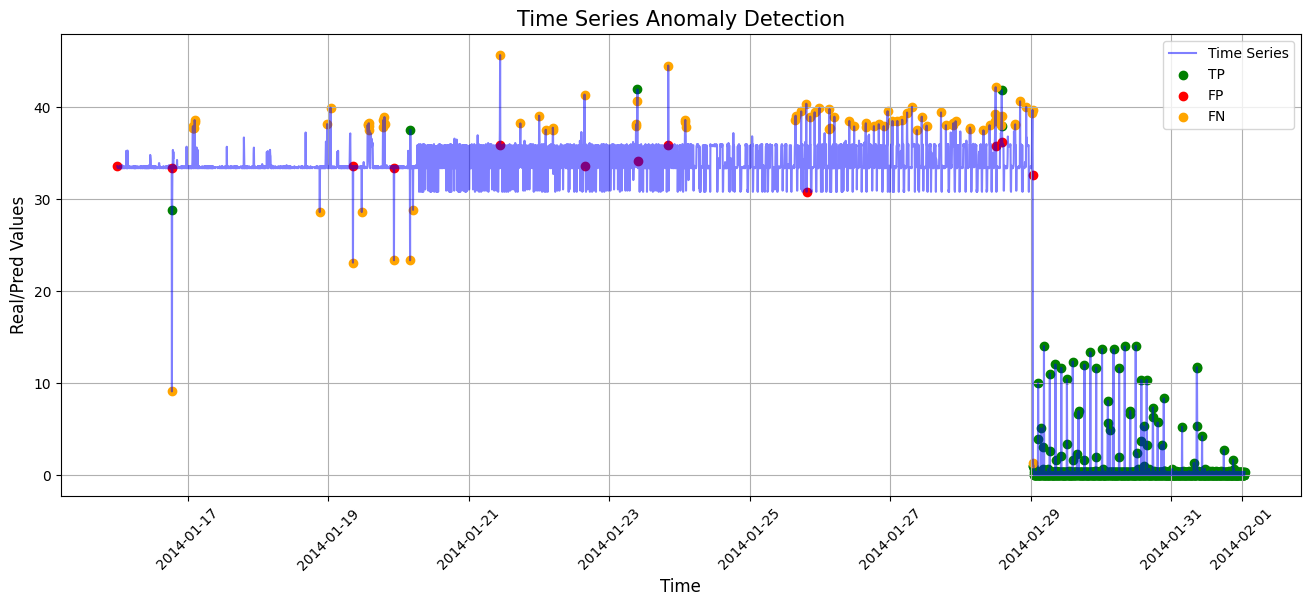

In [18]:
# Plot time series
plt.figure(figsize=(16, 6))

data['real_anomaly'] = (data['value'] > threshold_max) | (data['value'] < threshold_min)
data['pred_anomaly'] = (data['pred'] > threshold_max) | (data['pred'] < threshold_min)

# Identify TP, FP, FN
data['TP'] = (data['real_anomaly'] == 1) & (data['pred_anomaly'] == 1)
data['FP'] = (data['real_anomaly'] == 0) & (data['pred_anomaly'] == 1)
data['FN'] = (data['real_anomaly'] == 1) & (data['pred_anomaly'] == 0)

plt.plot(data.index, data['value'], label='Time Series', color = "blue", alpha=0.5)

# Add scatter points for TP, FP, FN
plt.scatter(data.index[data['TP']], data['value'][data['TP']], color='green', label='TP')
plt.scatter(data.index[data['FP']], data['value'][data['FP']], color='red', label='FP')
plt.scatter(data.index[data['FN']], data['value'][data['FN']], color='orange', label='FN')

# Customize plot
plt.xlabel('Time', fontsize = 12)
plt.xticks(rotation=45)
plt.ylabel('Real/Pred Values', fontsize = 12)
plt.title('Time Series Anomaly Detection', fontsize = 15)
plt.legend()
plt.grid()
plt.show()

In [19]:
# Previous Visualization
"""
plt.figure(figsize=(12, 6))
plt.plot(data['value'], label='Observed')
plt.plot(forecast, color='orange', label='Forecast')
plt.scatter(anomalies.index, anomalies['value'], color='red', label='Anomalies')
plt.legend()
plt.show()
"""

"\nplt.figure(figsize=(12, 6))\nplt.plot(data['value'], label='Observed')\nplt.plot(forecast, color='orange', label='Forecast')\nplt.scatter(anomalies.index, anomalies['value'], color='red', label='Anomalies')\nplt.legend()\nplt.show()\n"

### PCA

In [20]:
time_series = data["value"]

In [21]:
# Sliding window params
window_size = 10 
data_matrix = np.array([time_series[i:i+window_size].values for i in range(len(time_series) - window_size + 1)])
data_matrix.shape

(4612, 10)

In [22]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_matrix)

In [23]:
data_reconstructed = pca.inverse_transform(data_pca)
reconstruction_error = np.mean((data_matrix - data_reconstructed) ** 2, axis=1)

In [24]:
threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)
anomalies = reconstruction_error > threshold

In [25]:
# Previous Visualization
"""
plt.plot(reconstruction_error, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.scatter(np.where(anomalies), reconstruction_error[anomalies], color='red', label='Anomalies')
plt.legend()
plt.show()
"""

"\nplt.plot(reconstruction_error, label='Reconstruction Error')\nplt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')\nplt.scatter(np.where(anomalies), reconstruction_error[anomalies], color='red', label='Anomalies')\nplt.legend()\nplt.show()\n"

### N-BEATS

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [27]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3050 Laptop GPU (UUID: GPU-8035902b-e67f-11d8-46e6-b0daf1ccc112)


In [28]:
# TODO